In [84]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision.transforms import transforms
from torchmetrics import ROC
from torchmetrics import AUROC

from torch import nn

### Скачивание датасета FashionMNIST

In [28]:
train_dt = FashionMNIST(
    root='../data/',
    train=True,
    transform= transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5),(0.5))])
)
test_dt = FashionMNIST(
    root='../data/',
    train=False,
    transform= transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5),(0.5))])
)

In [29]:
cl_dict = dict(enumerate(FashionMNIST.classes))

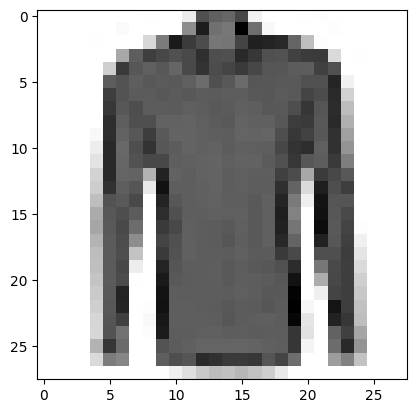

In [30]:
plt.imshow(train_dt[40][0].permute(1,2,0),cmap="Greys")

In [31]:
batch_size = 60

train_dtloader = DataLoader(train_dt,batch_size=batch_size)
test_dtloader = DataLoader(test_dt,batch_size=batch_size)

### Создание модели ConvNN

In [96]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1,2,5),
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2),
            nn.Conv2d(2,4,5),
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2),
        )
        self.flaten = nn.Flatten(1)
        self.linear_stack = nn.Sequential(
            nn.Linear(4*4*4,64),
            nn.ReLU(),
            nn.Linear(64,10),
        )
    
    def forward(self,x):
        x = self.conv_stack(x)
        x = self.flaten(x)
        x = self.linear_stack(x)
        return x

### Проверка на доступность GPU

In [107]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
net = ConvNet().to(device)

Using cuda device


In [108]:
optim = torch.optim.SGD(net.parameters(),lr=1e-2,momentum=0.9)
optim2 = torch.optim.Adam(net.parameters())
loss_fn = nn.CrossEntropyLoss()

### Обучение сети

проверка на тестовой выборке

In [109]:
def test(dataloader,loss_fn,model):
    roc = ROC(num_classes=10)
    roc_auc = AUROC(num_classes=10)
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct,test_roc  = 0, 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred_y = model(X)
            test_roc += roc_auc(pred_y,y).item()
            fpr, tpr, _ = roc(pred_y,y)
            test_loss += loss_fn(pred_y, y).item()
            correct += (pred_y.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    test_roc /= num_batches
    correct /= size
    plt.title("Test roc-auc")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])    
    plt.plot(np.mean(np.array([i.detach().cpu().numpy() for i in fpr]),axis=0),np.mean(np.array([i.detach().cpu().numpy() for i in tpr]),axis=0))
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.show()
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%,| roc_auc: {(100*test_roc):>0.1f}  Avg loss: {test_loss:>8f} \n")


обучение на тренировочной выборке

Epoch 1
-------------------------------
loss: 2.300333 | roc_auc: 0.533438 [    0/60000]
loss: 0.777191 | roc_auc: 0.924304 [ 6000/60000]
loss: 0.805954 | roc_auc: 0.926439 [12000/60000]
loss: 0.770925 | roc_auc: 0.935109 [18000/60000]
loss: 1.048560 | roc_auc: 0.914092 [24000/60000]
loss: 0.511298 | roc_auc: 0.953557 [30000/60000]
loss: 0.613064 | roc_auc: 0.956950 [36000/60000]
loss: 0.787908 | roc_auc: 0.944075 [42000/60000]
loss: 0.516778 | roc_auc: 0.975387 [48000/60000]
loss: 0.509924 | roc_auc: 0.959499 [54000/60000]
Train Error: 
 roc_auc: 0.9% 



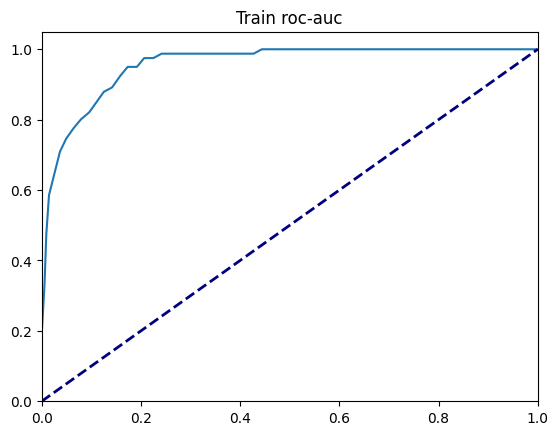

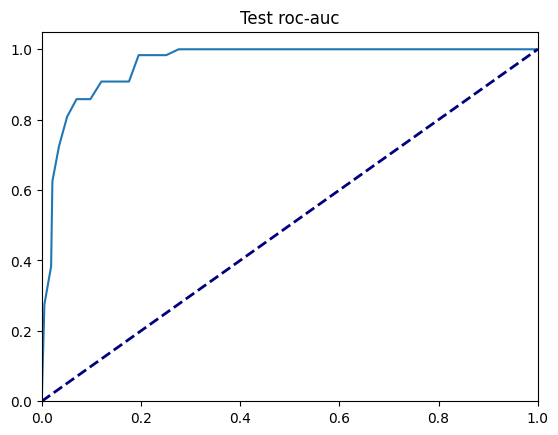

Test Error: 
 Accuracy: 78.5%,| roc_auc: 95.5  Avg loss: 0.555227 

Epoch 2
-------------------------------
loss: 0.526681 | roc_auc: 0.963832 [    0/60000]
loss: 0.541173 | roc_auc: 0.957478 [ 6000/60000]
loss: 0.434224 | roc_auc: 0.956970 [12000/60000]
loss: 0.515609 | roc_auc: 0.960618 [18000/60000]
loss: 0.949320 | roc_auc: 0.941240 [24000/60000]
loss: 0.341741 | roc_auc: 0.964059 [30000/60000]
loss: 0.572973 | roc_auc: 0.969318 [36000/60000]
loss: 0.639048 | roc_auc: 0.951458 [42000/60000]
loss: 0.504185 | roc_auc: 0.976461 [48000/60000]
loss: 0.428487 | roc_auc: 0.971398 [54000/60000]
Train Error: 
 roc_auc: 1.0% 



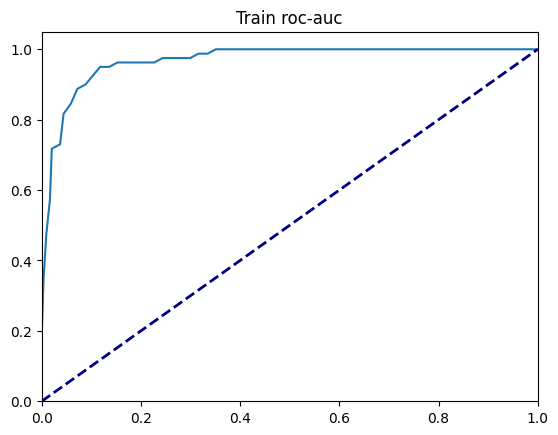

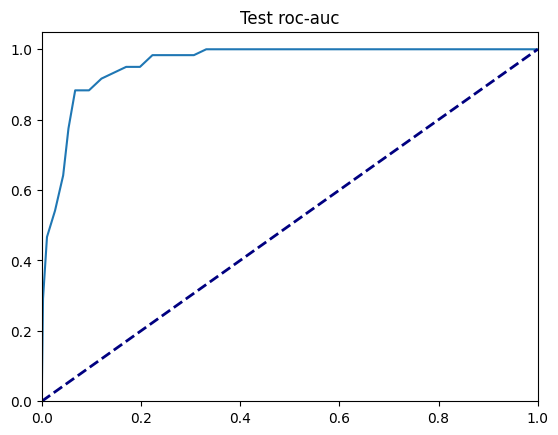

Test Error: 
 Accuracy: 82.1%,| roc_auc: 96.1  Avg loss: 0.483549 

Epoch 3
-------------------------------
loss: 0.438640 | roc_auc: 0.970359 [    0/60000]
loss: 0.512570 | roc_auc: 0.970665 [ 6000/60000]
loss: 0.373046 | roc_auc: 0.966400 [12000/60000]
loss: 0.499642 | roc_auc: 0.962093 [18000/60000]
loss: 0.887672 | roc_auc: 0.947878 [24000/60000]
loss: 0.316571 | roc_auc: 0.964258 [30000/60000]
loss: 0.493339 | roc_auc: 0.969582 [36000/60000]
loss: 0.630962 | roc_auc: 0.958309 [42000/60000]
loss: 0.478785 | roc_auc: 0.976083 [48000/60000]
loss: 0.323772 | roc_auc: 0.975157 [54000/60000]
Train Error: 
 roc_auc: 1.0% 



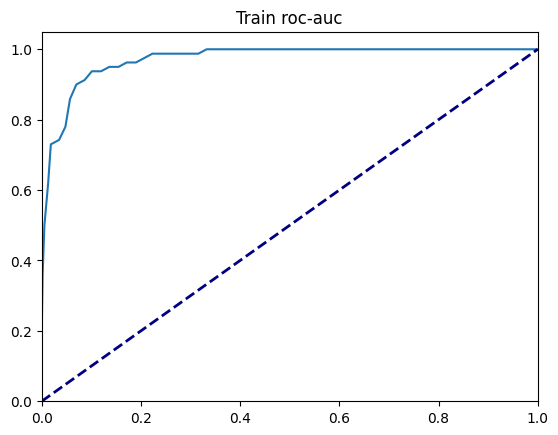

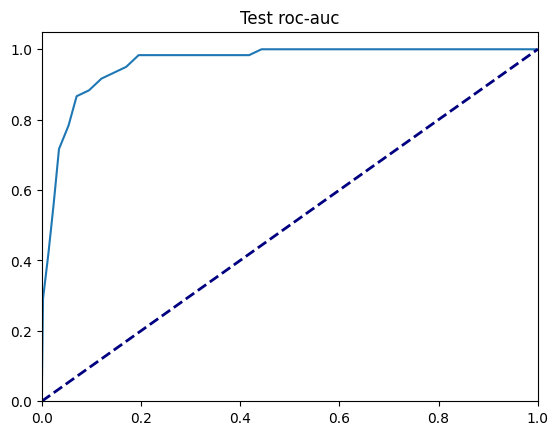

Test Error: 
 Accuracy: 83.5%,| roc_auc: 96.3  Avg loss: 0.448620 

Epoch 4
-------------------------------
loss: 0.352422 | roc_auc: 0.976619 [    0/60000]
loss: 0.452061 | roc_auc: 0.971899 [ 6000/60000]
loss: 0.291639 | roc_auc: 0.968190 [12000/60000]
loss: 0.485353 | roc_auc: 0.961799 [18000/60000]
loss: 0.864994 | roc_auc: 0.948408 [24000/60000]
loss: 0.306019 | roc_auc: 0.970469 [30000/60000]
loss: 0.451851 | roc_auc: 0.973070 [36000/60000]
loss: 0.627677 | roc_auc: 0.961404 [42000/60000]
loss: 0.477960 | roc_auc: 0.976799 [48000/60000]
loss: 0.296728 | roc_auc: 0.977339 [54000/60000]
Train Error: 
 roc_auc: 1.0% 



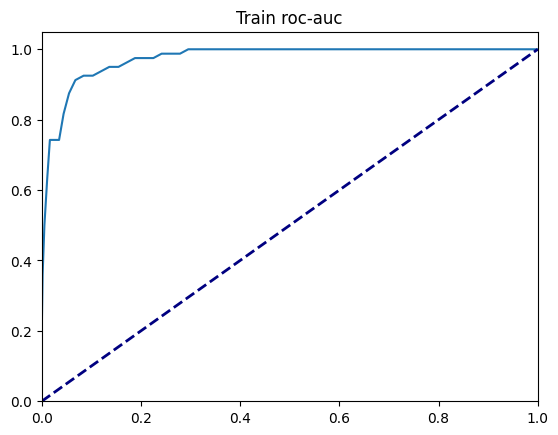

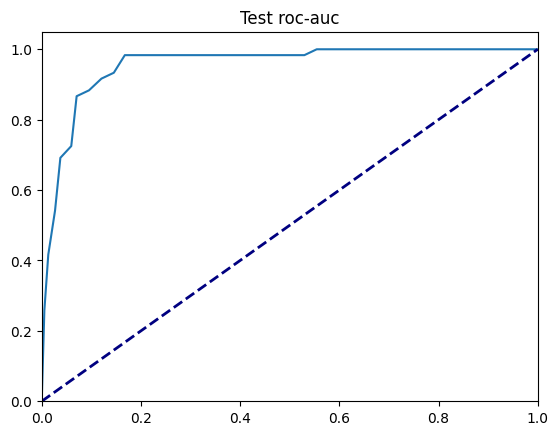

Test Error: 
 Accuracy: 84.1%,| roc_auc: 96.4  Avg loss: 0.439601 

Epoch 5
-------------------------------
loss: 0.320935 | roc_auc: 0.977663 [    0/60000]
loss: 0.419816 | roc_auc: 0.976158 [ 6000/60000]
loss: 0.262401 | roc_auc: 0.973568 [12000/60000]
loss: 0.464007 | roc_auc: 0.965663 [18000/60000]
loss: 0.828135 | roc_auc: 0.952297 [24000/60000]
loss: 0.295256 | roc_auc: 0.970427 [30000/60000]
loss: 0.445619 | roc_auc: 0.972173 [36000/60000]
loss: 0.578971 | roc_auc: 0.964994 [42000/60000]
loss: 0.451475 | roc_auc: 0.979894 [48000/60000]
loss: 0.296187 | roc_auc: 0.976709 [54000/60000]
Train Error: 
 roc_auc: 1.0% 



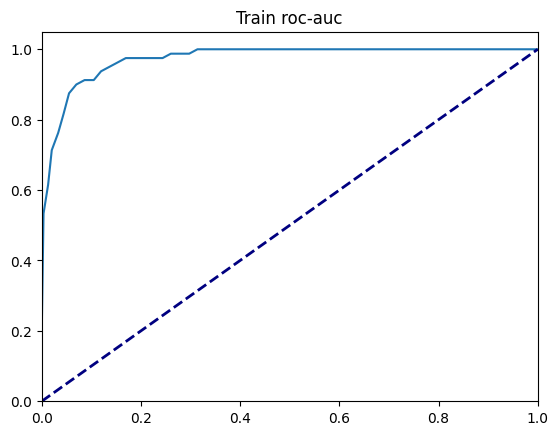

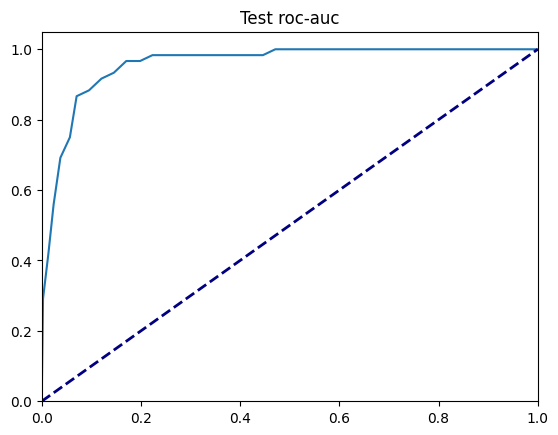

Test Error: 
 Accuracy: 84.2%,| roc_auc: 96.4  Avg loss: 0.436575 

Done!


In [110]:
epochs = 5
roc = ROC(num_classes=10)
roc_auc = AUROC(num_classes=10)
for t in range(epochs):
    roc_buf=[]
    print(f"Epoch {t+1}\n-------------------------------")
    net.train()
    size = len(train_dtloader.dataset)
    num_batches = len(train_dtloader)
    train_roc = 0
    for batch, (X,y) in enumerate(train_dtloader):
        X, y = X.to(device), y.to(device)
        y_pred = net(X)
        loss = loss_fn(y_pred,y)
        optim.zero_grad()
        loss.backward()
        optim.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            fpr, tpr, _ = roc(y_pred,y)
            train_roc += roc_auc(y_pred,y)
            print(f"loss: {loss:>7f} | roc_auc: {roc_auc(y_pred,y):>7f} [{current:>5d}/{size:>5d}]")
    train_roc /= num_batches
    print(f"Train Error: \n roc_auc: {(100*train_roc):>0.1f}% \n")        

    
    plt.title("Train roc-auc")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])    
    plt.plot(np.mean(np.array([i.detach().cpu().numpy() for i in fpr]),axis=0),np.mean(np.array([i.detach().cpu().numpy() for i in tpr]),axis=0))
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.show()
    test(test_dtloader, loss_fn, net)
    
print("Done!")

### Проверка модели

In [130]:
Image_num = 6

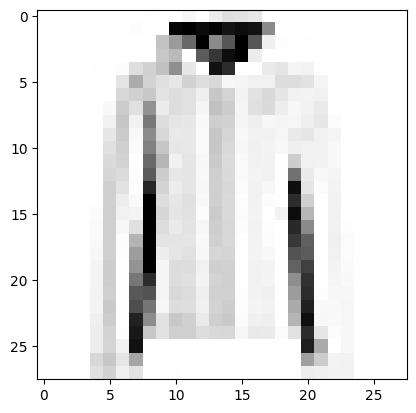

4
Coat


In [131]:
net.eval()
plt.imshow(test_dt[Image_num][0].permute(1,2,0),cmap="Greys")
plt.show()
with torch.no_grad():
    _, pred = torch.max(net(test_dt[Image_num][0][None].to(device)),1)
    print(pred.item())
    print(cl_dict[pred.item()])